In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import curve_fit

import pandas as pd
import matplotlib.pyplot as plt

### Upload Hand Data

In [2]:
emp_data = None
date = '09112020-1104'
emp_data = pd.read_excel('../Assets/Resources/DataSimulation/Speeds/' + date + '.xlsx')

### Turn it into positions

In [3]:
positions = None
positions = pd.DataFrame()
positions['Time'] = emp_data['Time']
positions['Phalanx_0'] = emp_data['RightPos']

for i in range(1,19):
    positions['Phalanx_' + str(i) ] = emp_data['RightPos.' + str(i)]

### And Calculate speeds (differentiate)

In [4]:
speeds = None
filter_choice = 30
speeds = pd.DataFrame()
speeds['Time'] = positions['Time'][0:len(emp_data['Time']) - filter_choice]
for i in range(0, 19):
    for j in range(0, len(emp_data['Time']) - filter_choice):
        speeds['Phalanx_' + str(i)] =  (positions['Phalanx_' + str(i)][j+filter_choice] - positions['Phalanx_' + str(i) ][j])/(positions['Time'][j+filter_choice] - positions['Time'][j])

for i in range(0, 19):
    for j in range(0, len(emp_data['Time']) - filter_choice):
        speeds['Phalanx_' + str(i)].loc[j] = (positions['Phalanx_' + str(i)][j+filter_choice] - positions['Phalanx_' + str(i) ][j])/(positions['Time'][j+filter_choice] - positions['Time'][j])

## Define Threshold to start the Fitting process

In [5]:
threshold = 0.03 #m/s
v_start = abs(speeds['Phalanx_0'] >= threshold)

In [6]:
index_start = None
index_start = pd.DataFrame()
index_stop = None
index_stop = pd.DataFrame()
j = 0
k = 0

for i in range(0, len(speeds) - 1):
    if((v_start[i+1] == True) & (v_start[i] == False)):
        #index_start = index_start, i+1
        index_start[j] = i+1
    if((v_start[i+1] == False) & (v_start[i] == True)):
        index_stop[k] = i+1
    
for i in range(0, len(speeds) - 1):
    if((v_start[i+1] == True) & (v_start[i] == False)):
        #index_start = index_start, i+1
        j = j+1
    index_start.loc[j] = i+1
    if((v_start[i+1] == False) & (v_start[i] == True)):
        k = k+1
    index_stop.loc[k] = i+1 
    
#index_start = index_start.transpose()
#index_stop = index_stop.transpose()

## Index_Start[i][0] matches the start of the i_th grasping phase, while Index_stop[i][0] matches their end (start - end hence corresponds to the duration of the movement).

### Len(Index_Start) corresponds to the number of touch

### Define Minimum Jerk function

In [28]:
def jerk_model_real( t, tf, xf):
    
    return (xf - x0)/(tf) * (30*((t - t0)/(tf - t0))**2 - 60*((t - t0)/(tf - t0))**3 + 30*((t - t0)/(tf - t0))**4)

In [8]:
def jerk_model_real( t, tf, xf):
    
    return (xf)/(tf) * (30*((t)/(tf))**2 - 60*((t)/(tf))**3 + 30*((t)/(tf))**4)

16.19455 17.8747 65 115 50 12
Predicted Duration Trial#0: 0.35 s
Real Duration Trial#0: 1.68 s
Difference Predicted/Real Trial#0: 1.33 s
22.08234 23.63823 250 305 55 17
Predicted Duration Trial#1: 0.48 s
Real Duration Trial#1: 1.56 s
Difference Predicted/Real Trial#1: 1.08 s
25.97853 27.90278 387 454 67 16
Predicted Duration Trial#2: 0.46 s
Real Duration Trial#2: 1.92 s
Difference Predicted/Real Trial#2: 1.46 s
31.37448 33.74252 575 658 83 25
Predicted Duration Trial#3: 0.72 s
Real Duration Trial#3: 2.37 s
Difference Predicted/Real Trial#3: 1.65 s
36.3144 38.22649 748 814 66 27
Predicted Duration Trial#4: 0.79 s
Real Duration Trial#4: 1.91 s
Difference Predicted/Real Trial#4: 1.12 s
40.8028 42.11824 904 949 45 37
Predicted Duration Trial#5: 1.09 s
Real Duration Trial#5: 1.32 s
Difference Predicted/Real Trial#5: 0.22 s
44.89451 46.26627 1046 1095 49 37
Predicted Duration Trial#6: 1.04 s
Real Duration Trial#6: 1.37 s
Difference Predicted/Real Trial#6: 0.34 s
49.13043 51.2145 1193 1264 71

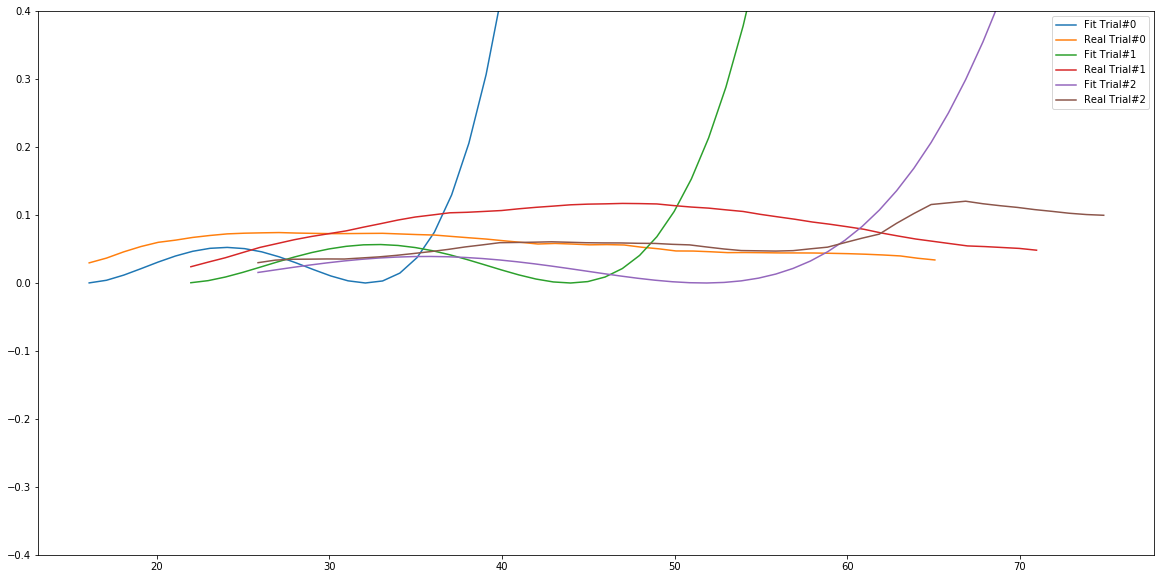

In [68]:
input_data = None
window = 4 # 3-4 approx 100ms
time_steps = 100

index_predicted_stop = None
index_predicted_stop = pd.DataFrame()

record_predictions = None
record_predictions = pd.DataFrame()
plt.figure(figsize=(20,10))
#plt.axis = ([0, positions['Phalanx_0'][index_start[0][len(index_stop)] + window], -0.5, 0.5])


#plt.plot(speeds['Time'], speeds['Phalanx_0'])
plt.axis = ([0, 130, -0.5, 0.5])
for i in range(0, len(index_stop) - 1):
    input_data = speeds['Phalanx_0'][index_start[0][i] - window : index_start[0][i] + window]
    #input_data = speeds['Phalanx_0'][index_start[0][i]: index_start[0][i] + window]

    x0 = positions['Phalanx_0'][index_start[0][i] - window]
    t0 = speeds['Time'][index_start[0][i] - window]
    
    # Fit Input data
    param_jerk, covar = curve_fit(jerk_model_real, np.arange(2*window), input_data)
    #param_jerk, covar = curve_fit(jerk_model_real, np.arange(window), input_data)

    # Define simulation based on fit parameters
    simulation_speed = jerk_model_real(np.arange(time_steps), *param_jerk)
    
    #if ((i == 0) | (i == 1)):
    #    plt.plot(np.arange(50), simulation_speed[0:50], label = "Fit Trial#" + str(i))
    #    plt.plot(np.arange(50), speeds['Phalanx_0'][index_start[0][i] : index_start[0][i] + 50], label = "Real Trial#" + str(i))
    #    plt.legend()
    
    if (i in range(0, 3)):
        plt.plot(t0 + np.arange(50), simulation_speed[0:50], label = "Fit Trial#" + str(i))
        plt.plot(t0 + np.arange(50), speeds['Phalanx_0'][index_start[0][i] : index_start[0][i] + 50], label = "Real Trial#" + str(i))
        plt.ylim(-0.4, 0.4)
        plt.legend()
    
    
    #plt.plot(t0 + np.arange(50), simulation_speed[0:50], label = "Fit Trial#" + str(i))
    #plt.legend()
    
    
    # Define threshold to predict ETA
    v_stop = abs(simulation_speed) < threshold
    
    k = 0
    for j in range(0, (time_steps - 1) ):
        if( (v_stop[j] == False) & (v_stop[j+1] == True) ):
            index_predicted_stop[k] = j+1
        
        if( (v_stop[j] == False) & (v_stop[j+1] == True) ):
            k = k+1
            index_predicted_stop.loc[k] = j+1
            
    record_predictions = record_predictions.append(index_predicted_stop)
    
    duration_pred = speeds['Time'][index_start[0][i] + record_predictions.iloc[i][0]] - speeds['Time'][index_start[0][i]]
    duration_real = speeds['Time'][index_stop[0][i]] - speeds['Time'][index_start[0][i]]
    error_ETA = abs((speeds['Time'][index_start[0][i] + record_predictions.iloc[i][0]] - speeds['Time'][index_start[0][i]])  - (speeds['Time'][index_stop[0][i]] - speeds['Time'][index_start[0][i]]))
    
    print(speeds['Time'][index_start[0][i]], speeds['Time'][index_stop[0][i]], index_start[0][i], index_stop[0][i], - index_start[0][i] + index_stop[0][i], record_predictions.iloc[i][0])
    print("Predicted Duration Trial#" + str(i) + ": %.2f" % duration_pred + " s")
    print("Real Duration Trial#" + str(i) + ": %.2f" % duration_real + " s")
    print("Difference Predicted/Real Trial#" + str(i) + ": %.2f" % error_ETA + " s")
plt.show()    

In [69]:
index_start[0][i] - window

3690

In [70]:
len(index_stop)

27

In [71]:
record_predictions.iloc[0][0], record_predictions.iloc[1][0], record_predictions.iloc[2][0]

(12, 17, 16)

In [73]:
def jerk_model_position(t, xf):
    
    return x0 + (xf - x0)*(10*((t - t0)/(tf - t0))**3 - 15*((t - t0)/(tf - t0))**4 + 6*((t - t0)/(tf - t0))**5)

In [96]:
plt.axis = ([0, 130, -0.5, 0.5])
for i in range(0, len(index_stop) - 1):
    
    x0 = positions['Phalanx_0'][index_start[0][i]]
    t0 = positions['Time'][index_start[0][i]]
    tf = positions['Time'][index_start[0][i] + record_predictions.iloc[i][0]]
    
    t = positions['Time'][index_start[0][i]:index_start[0][i]+window] - positions['Time'][index_start[0][i]]

    # Fit Input data
    param_jerk_pos, covar = curve_fit(jerk_model_position, np.arange(window), positions['Phalanx_0'][index_start[0][i]:index_start[0][i]+window])
    #param_jerk, covar = curve_fit(jerk_model_real, np.arange(window), input_data)

    # Define simulation based on fit parameters
    predicted_pos = jerk_model_position(np.arange(time_steps), param_jerk_pos[0])

    #plt.plot(positions['Time'][index_start[0][i]:index_start[0][i]+window], x0 + (param_jerk_pos[0] - x0)*(10*((t-t0)/(tf-t0))**3 - 15*((t-t0)/(tf-t0))**4 + 6*((t-t0)/(tf-t0))**5), label = 'Fit')
    #plt.plot(positions['Time'][index_start[0][i]:index_start[0][i]+window], positions['Phalanx_0'][index_start[0][i]:index_start[0][i]+window], label = 'Input')
    #plt.legend()
  #  error_pos = abs((positions['Phalanx_0'][index_start[0][i] + record_predictions.iloc[i][0]] - positions['Phalanx_0'][index_start[0][i]])  - (positions['Phalanx_0'][index_stop[0][i]]) )# - positions['Phalanx_0'][index_start[0][i]]))
  #  error_pos = 100 * abs((positions['Phalanx_0'][index_start[0][i] + record_predictions.iloc[i][0]] - positions['Phalanx_0'][index_stop[0][i]]) )
    error_pos = 100 * abs(predicted_pos[index_stop[0][i] - index_start[0][i]] - positions['Phalanx_0'][index_stop[0][i]])
    print("Difference Position Predicted/Real Trial#" + str(i) + ": %.2f" % error_pos + " cm")


Difference Position Predicted/Real Trial#0: 20.43 cm
Difference Position Predicted/Real Trial#1: 8.24 cm
Difference Position Predicted/Real Trial#2: 9.40 cm
Difference Position Predicted/Real Trial#3: 10.61 cm
Difference Position Predicted/Real Trial#4: 12.53 cm
Difference Position Predicted/Real Trial#5: 5.40 cm
Difference Position Predicted/Real Trial#6: 11.48 cm
Difference Position Predicted/Real Trial#7: 7.79 cm
Difference Position Predicted/Real Trial#8: 9.18 cm
Difference Position Predicted/Real Trial#9: 0.19 cm
Difference Position Predicted/Real Trial#10: 9.06 cm
Difference Position Predicted/Real Trial#11: 9.59 cm
Difference Position Predicted/Real Trial#12: 7.23 cm
Difference Position Predicted/Real Trial#13: 6.33 cm
Difference Position Predicted/Real Trial#14: 9.79 cm
Difference Position Predicted/Real Trial#15: 8.35 cm
Difference Position Predicted/Real Trial#16: 7.18 cm
Difference Position Predicted/Real Trial#17: 8.58 cm
Difference Position Predicted/Real Trial#18: 9.60 cm